# Slot regression

**Goal:** This notebook is a diagnostic where I'm trying to regress the slot position and energy from the queries if I leave everything the same for the query vector.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.nn import init
import torch.nn.functional as F

# IO pkgs
import yaml, json
from glob import glob

# custom code
import os
os.sys.path.append('code')
from plotting import plot_kslots, plot_kslots_iters
from data import make_batch
from train import hungarian_matching
from model import SlotAttentionPosEmbed

%load_ext autoreload
%autoreload 2

**Load in the model**

In [4]:
cID_prev = 'learn-init-warm2'
device='cuda:0'

In [6]:
with open(f'code/configs/{cID_prev}.yaml') as f:
    cd = yaml.safe_load(f)


hps = cd['hps']
hps['device'] = device
# hps['learn_slot_feat'] = True

kwargs = cd['data']
kwargs['device'] = device
hps

{'hidden_dim': 16,
 'k_slots': 3,
 'query_dim': 128,
 'softmax_T': 'default',
 'learn_init': True,
 'device': 'cuda:0'}

In [24]:
m_base = SlotAttentionPosEmbed(**hps).to(device)

lastIter = 400_000
modelToLoad = f'code/models/{cID_prev}/m_{lastIter}.pt'
print(f'Starting from an earlier training',lastIter)

m_base.load_state_dict(torch.load(modelToLoad,map_location=device),strict=False)

Starting from an earlier training 400000


<All keys matched successfully>

In [63]:
query_dim = hps['query_dim']
hidden_dim  = hps['hidden_dim']

m_reg = torch.nn.Sequential(
                torch.nn.Linear(query_dim,query_dim),
                torch.nn.ReLU(),
                torch.nn.Linear(query_dim,query_dim),
                torch.nn.ReLU(),
                torch.nn.Linear(query_dim,hidden_dim),
                            torch.nn.ReLU(),
                torch.nn.Linear(hidden_dim,hidden_dim),
                            torch.nn.ReLU(),
                torch.nn.Linear(hidden_dim, 3)
            ).to(device)

In [64]:
cID = f'reg-{query_dim}-{query_dim}-{query_dim}-{hidden_dim}-{hidden_dim}-3'

modelDir = f'code/models/{cID}'
figDir = f'code/figures/{cID}'

# for d in [modelDir,figDir]:
#     os.mkdir(d)

**Set up the training loop**

In [65]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Circle

def plot_chosen_slots(losses, mask, att_img, Y_true, Y_pred, color='C0',cmap='Blues',figname=''):
    n_rings = att_img.shape[0]
    fig, axs = plt.subplots(1,n_rings+2,figsize=(3*(n_rings + 2) ,2.5))

    axs[0].plot(losses,color=color)
    axs[0].set_xlabel('Iters')
    axs[0].set_ylabel('Loss')
    # axs[0].legend()
    
    imgs   = [mask] + [att_img[i] for i in range(n_rings)]
    titles = ['Target']+[f'Slot {i}' for i in range(n_rings)]
    extent = [-0.5, 0.5]*2
    for i, (ax,img,title) in enumerate(zip(axs[1:],imgs, titles)):
        
        im = ax.imshow(img.detach().cpu().numpy(),cmap=cmap,
                       extent=extent,origin='lower') #,vmin=0,vmax=1)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

        ax.set_title(title)
        

    # Add on the target image
    axi = axs[1]
    c_true = 'r'
    c_pred = 'k'
    for yi in Y_true.cpu().numpy():
    
        axi.scatter(*yi[:2],marker='x',color=c_true)
        circle = Circle(yi[:2],yi[2],fill=False,color=c_true)
        axi.add_patch(circle)
        
        axi.set_xlim(-0.5,0.5)
        axi.set_ylim(-0.5,0.5)
    
    for axi,yi,oi in zip(axs[2:],Y_true.cpu().numpy(),Y_pred.detach().cpu().numpy()):
        
        axi.scatter(*yi[:2],marker='x',color=c_true)
        circle = Circle(yi[:2],yi[2],fill=False,color=c_true)
        axi.add_patch(circle)
        
        axi.scatter(*oi[:2],marker='x',color=c_pred)
        circle = Circle(oi[:2],oi[2],fill=False,color=c_pred)
        axi.add_patch(circle)

        axi.set_xlim(-0.5,0.5)
        axi.set_ylim(-0.5,0.5)
        
    if figname:
        plt.savefig(figname)

    plt.show()
    plt.close()

In [66]:
max_n_rings = 2
k_slots = 3

In [67]:
def bce_loss(att,flat_mask):
    '''
    Predict the BCE loss for all comb of slots and rings
    '''
    att_ext  = torch.tile(att.unsqueeze(2), dims=(1,1,max_n_rings,1)) 
    mask_ext = torch.tile(flat_mask.unsqueeze(1),dims=(1,k_slots,1,1)) 
    
    return F.binary_cross_entropy(att_ext,mask_ext,reduction='none').mean(axis=-1)


In [68]:
def train(m_base,
          m_reg,
          Ntrain = 5000, 
          bs=32, 
          lr=3e-4,
          warmup_steps=5_000,
          alpha=1,
          losses = [],
          kwargs={'isRing': True, 'N_clusters':2},
          device='cpu',
          plot_every=250, 
          save_every=1000,
          color='C0',cmap='Blues',
          modelDir='.',figDir='',showImg=True):
    '''
    train -- arguments copied from Lukas's fct (see train.py)
    '''

    # Learning rate schedule config
    base_learning_rate = lr
    
    opt = torch.optim.Adam(m_reg.parameters(), base_learning_rate)
    
    m_reg.train()
    
    k_slots = m_base.k_slots
    max_n_rings = kwargs['N_clusters']
    resolution = m_base.resolution
    kwargs['device'] = device

    start = len(losses)
    for i in range(start,start+Ntrain):

        learning_rate = base_learning_rate * 0.5 * (1 + np.cos(np.pi * i / Ntrain))
        if i < warmup_steps:
            learning_rate *= (i / warmup_steps)
        
        opt.param_groups[0]['lr'] = learning_rate
        
        X, Y, mask = make_batch(N_events=bs, **kwargs)
        
        queries, att, wts = m_base(X)
            
        Y_pred = m_reg(queries)
            
        # Reshape the target mask to be flat in the pixels (same shape as att)
        flat_mask = mask.reshape(-1,max_n_rings, np.prod(resolution))      
        with torch.no_grad():
            
            pairwise_cost = bce_loss(att,flat_mask)
            indices = hungarian_matching(pairwise_cost)

        # Apply the sorting to the predict
        bis=torch.arange(bs).to(device)
        indices=indices.to(device)

        # Get the chosen rings and slots for the plots
        slots_sorted = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
        rings_sorted = torch.cat([flat_mask[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

        # l_bce = F.binary_cross_entropy(slots_sorted,rings_sorted,reduction='none').sum(axis=1).mean()

        '''
        Grad descent on MSE loss
        '''
        Y_pred_sorted = torch.cat([Y_pred[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
        Y_true_sorted = torch.cat([Y[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

        li = torch.nn.MSELoss(reduction='none')(Y_pred_sorted,Y_true_sorted).sum(axis=1).mean()
    
        li.backward()
        opt.step()
        opt.zero_grad()
        
        losses.append(float(li))
        
        if i % plot_every == 0:
            print('iter',i,', loss',li.detach().cpu().numpy(),', lr',opt.param_groups[0]['lr'])
            
            iEvt = 0
            att_sorted  = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
            
            att_img = att_sorted[iEvt].reshape(max_n_rings,*resolution)

            plot_chosen_slots(losses,mask[iEvt].sum(axis=0), att_img,
                              Y_true_sorted[iEvt],Y_pred_sorted[iEvt])
            
        if (i % save_every == 0) and modelDir:
            torch.save(m_reg.state_dict(), f'{modelDir}/m_{i}.pt')
            with open(f'{modelDir}/loss.json','w') as f:
                json.dump(losses, f)

    model.eval()
    return model,losses

/gpfs/slac/atlas/fs1/d/nhartman/Slot Attention/code/data.py:94: RuntimeWarning: invalid value encountered in true_divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 0 , loss 0.12770037 , lr 0.0


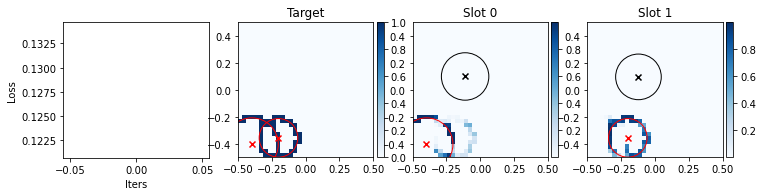

iter 100 , loss 0.12496176 , lr 5.9985196810971945e-06


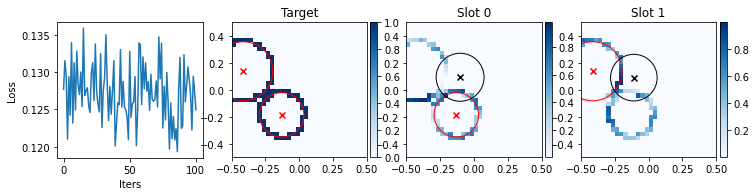

iter 200 , loss 0.113759026 , lr 1.1988160370569629e-05


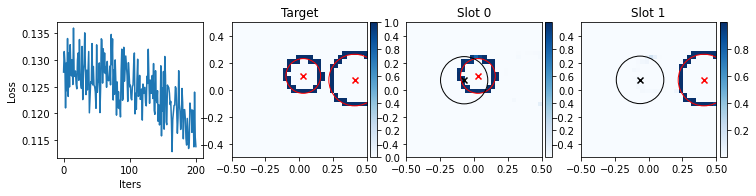

iter 300 , loss 0.10652304 , lr 1.7960057681427716e-05


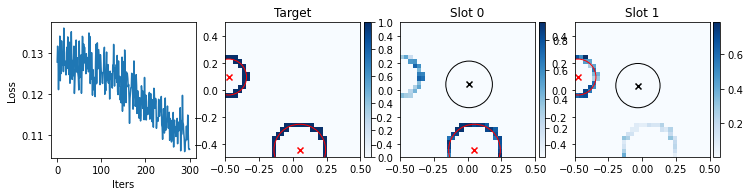

iter 400 , loss 0.102944754 , lr 2.3905376415773736e-05


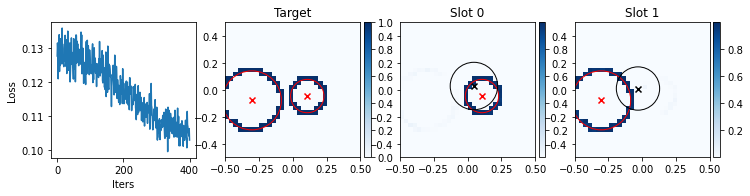

iter 500 , loss 0.10131671 , lr 2.9815325108927066e-05


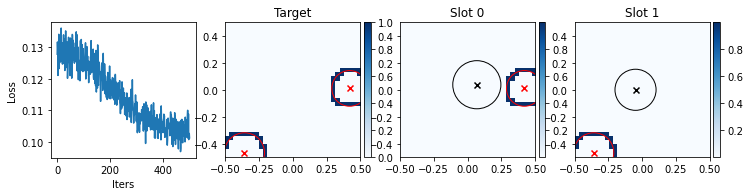

iter 600 , loss 0.09705554 , lr 3.5681170513116396e-05


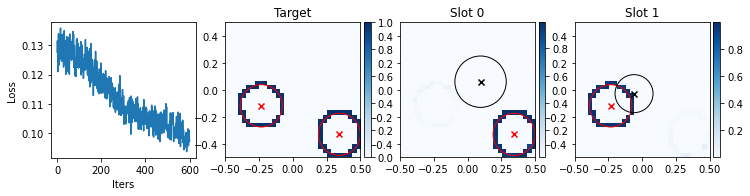

iter 700 , loss 0.09873843 , lr 4.14942520007137e-05


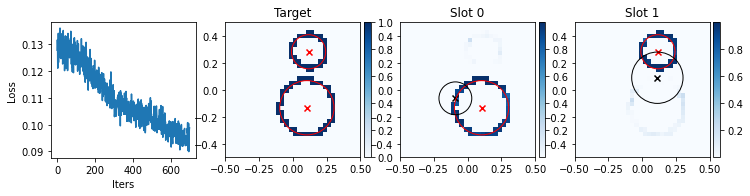

iter 800 , loss 0.09210797 , lr 4.7245995867087144e-05


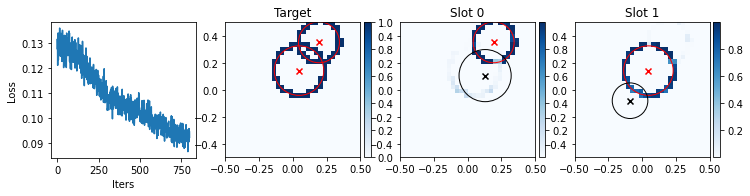

iter 900 , loss 0.09073397 , lr 5.2927929513277454e-05


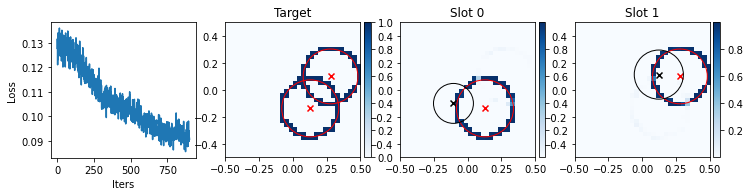

iter 1000 , loss 0.09250419 , lr 5.853169548885461e-05


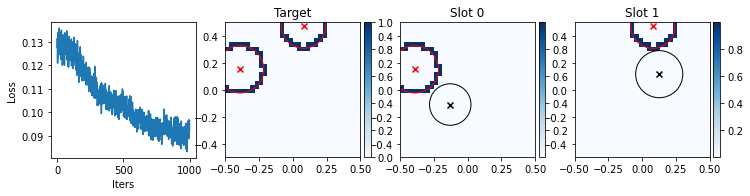

iter 1100 , loss 0.08751939 , lr 6.404906537548944e-05


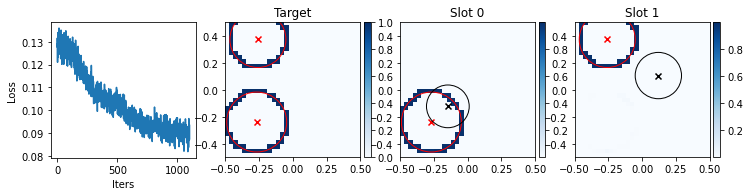

iter 1200 , loss 0.08815243 , lr 6.947195349197704e-05


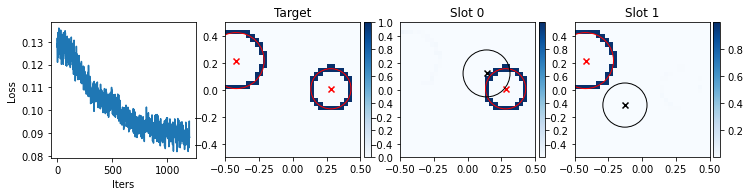

iter 1300 , loss 0.08129178 , lr 7.479243040167526e-05


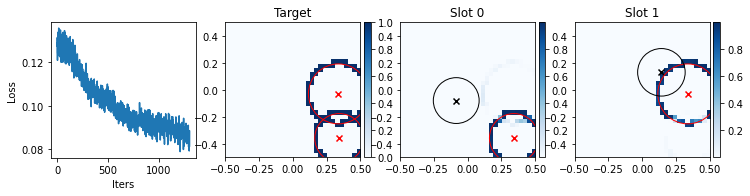

iter 1400 , loss 0.07903713 , lr 8.000273620357283e-05


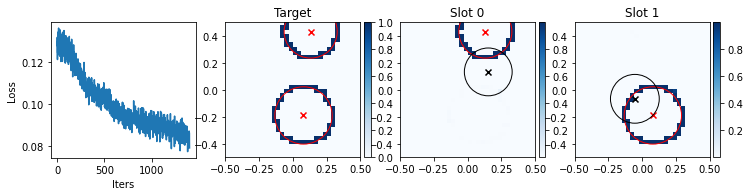

iter 1500 , loss 0.08003656 , lr 8.509529358847654e-05


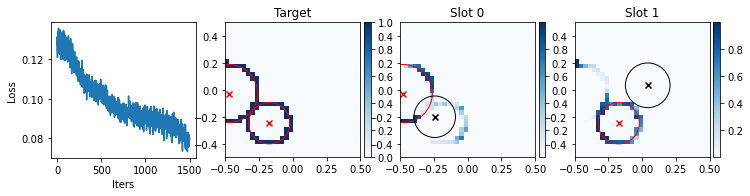

iter 1600 , loss 0.07334146 , lr 9.006272064210544e-05


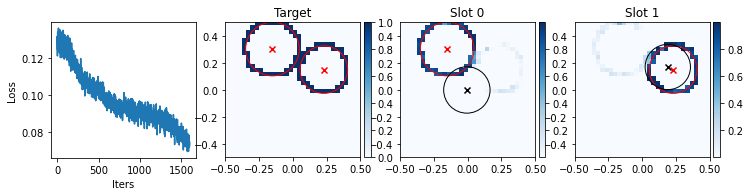

iter 1700 , loss 0.07434583 , lr 9.489784337720112e-05


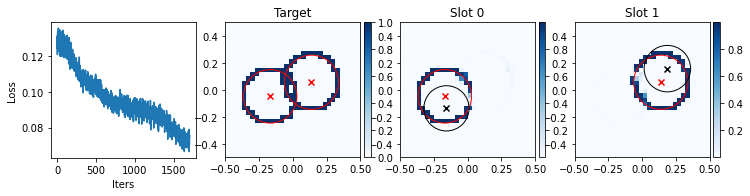

iter 1800 , loss 0.07264763 , lr 9.95937079771088e-05


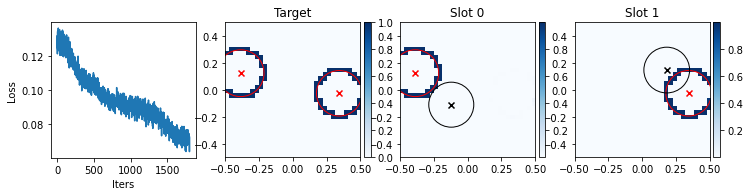

iter 1900 , loss 0.07492407 , lr 0.00010414359273365001


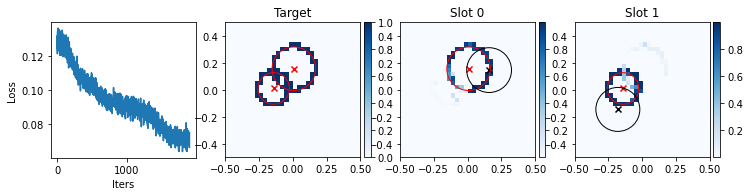

iter 2000 , loss 0.06679015 , lr 0.00010854101966249685


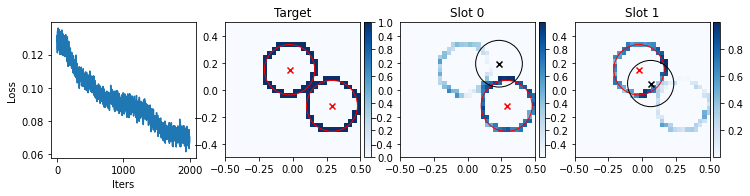

iter 2100 , loss 0.074691184 , lr 0.00011277976577966846


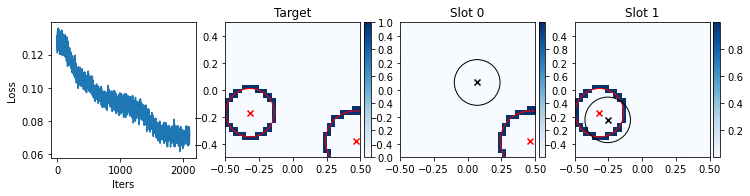

iter 2200 , loss 0.06957485 , lr 0.00011685387402320208


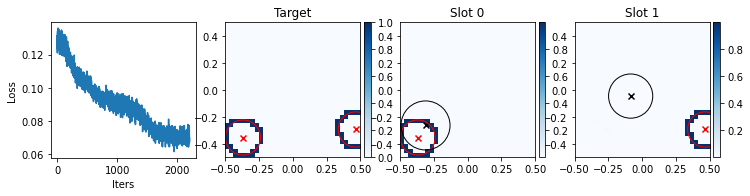

iter 2300 , loss 0.06625012 , lr 0.0001207576638045017


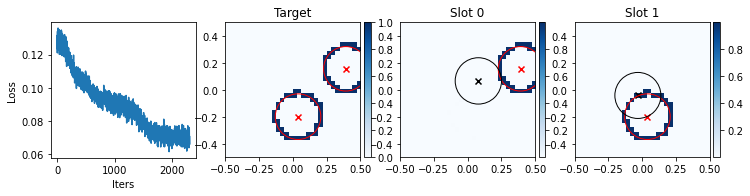

iter 2400 , loss 0.06863168 , lr 0.00012448574117434163


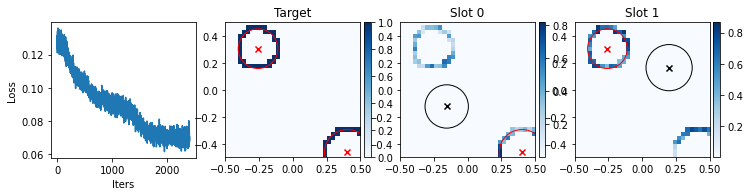

iter 2500 , loss 0.064854205 , lr 0.00012803300858899104


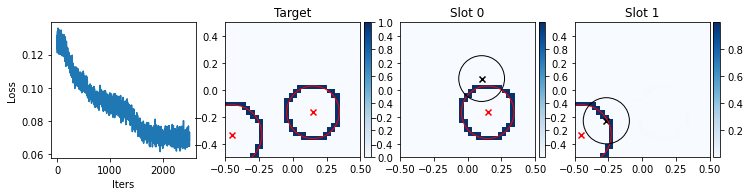

iter 2600 , loss 0.06906506 , lr 0.00013139467426243772


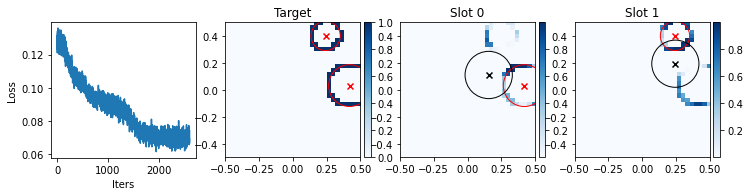

iter 2700 , loss 0.06295494 , lr 0.0001345662610912158


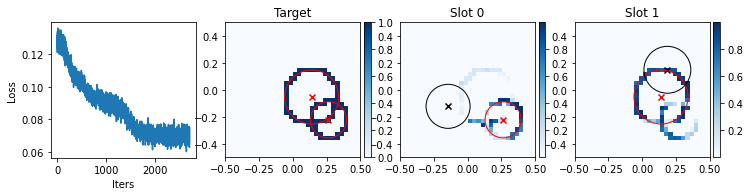

iter 2800 , loss 0.06877993 , lr 0.00013754361513888992


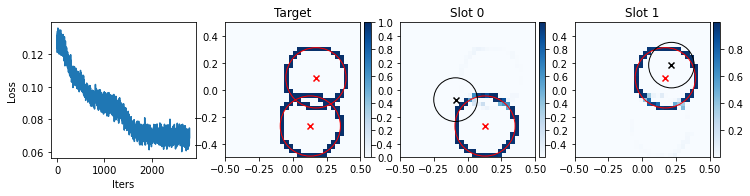

iter 2900 , loss 0.06910079 , lr 0.00014032291366780893


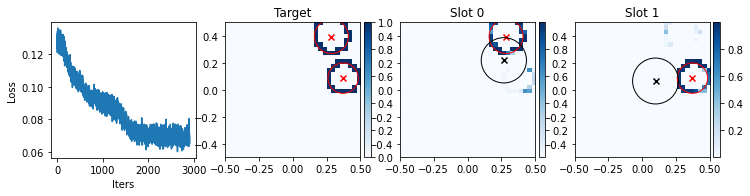

iter 3000 , loss 0.0657638 , lr 0.00014290067270632256


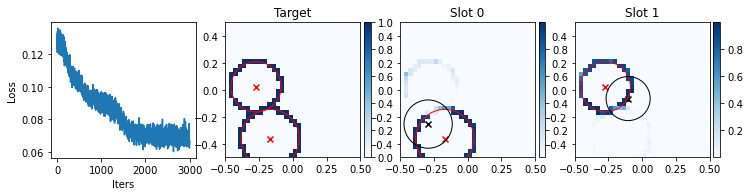

iter 3100 , loss 0.06672746 , lr 0.00014527375414024812


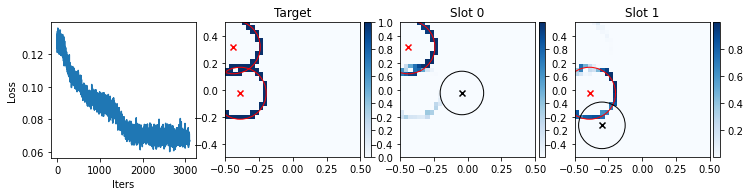

iter 3200 , loss 0.06798789 , lr 0.00014743937231798365


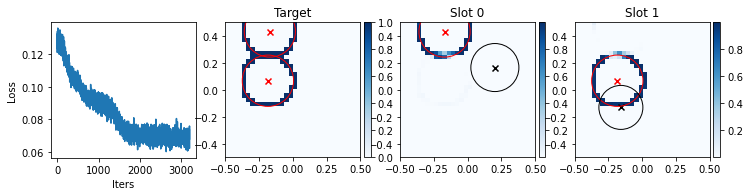

iter 3300 , loss 0.071525544 , lr 0.00014939510015928674


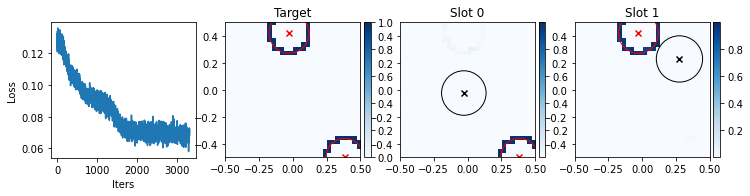

iter 3400 , loss 0.06654632 , lr 0.00015113887475837494


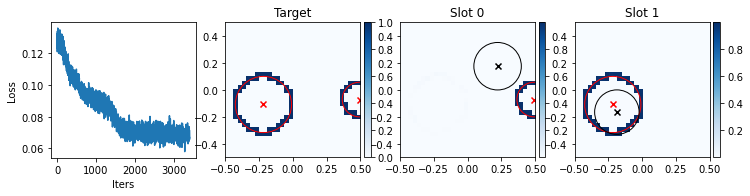

iter 3500 , loss 0.073463246 , lr 0.00015266900247265237


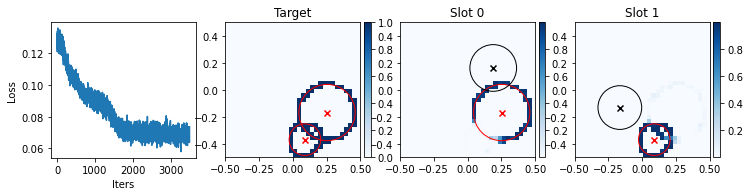

iter 3600 , loss 0.06913305 , lr 0.0001539841634890278


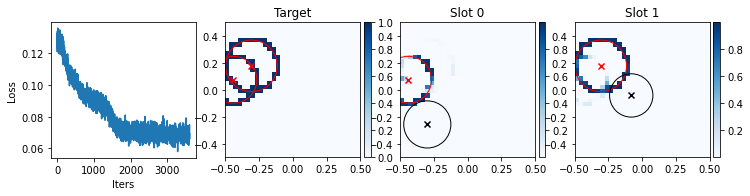

iter 3700 , loss 0.06816426 , lr 0.00015508341586046063


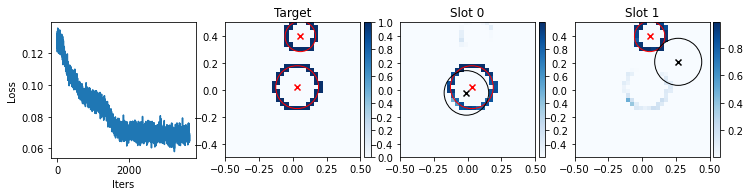

iter 3800 , loss 0.06832515 , lr 0.00015596619900605326


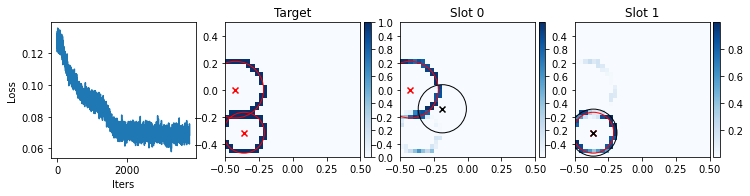

iter 3900 , loss 0.07081869 , lr 0.00015663233666869905


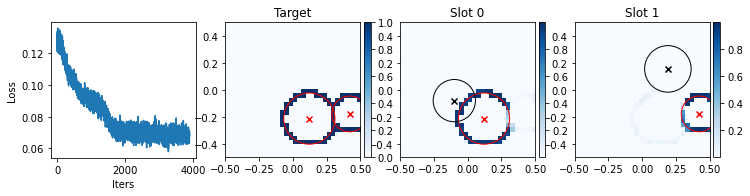

iter 4000 , loss 0.06871387 , lr 0.00015708203932499369


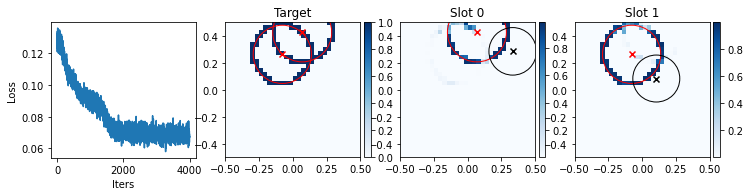

iter 4100 , loss 0.06770446 , lr 0.00015731590604282518


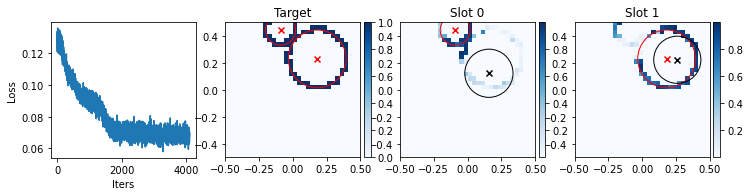

iter 4200 , loss 0.06743041 , lr 0.00015733492578277167


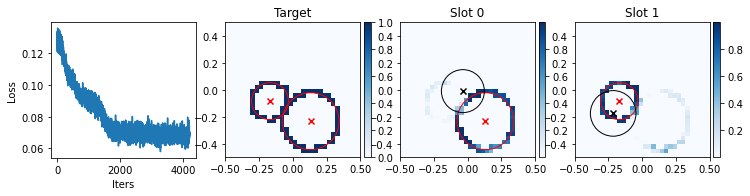

iter 4300 , loss 0.06699869 , lr 0.000157140478140154


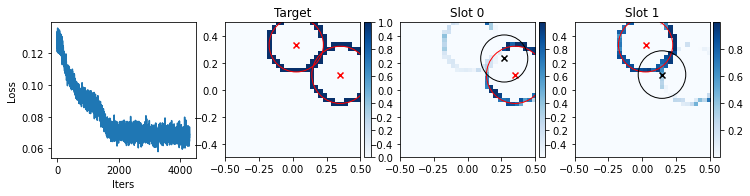

iter 4400 , loss 0.07594886 , lr 0.00015673433352531566


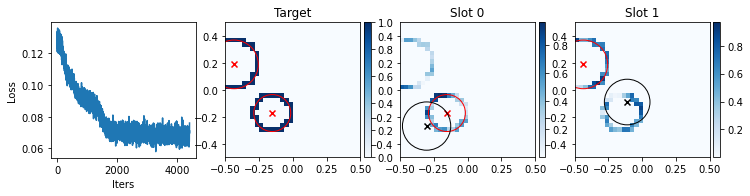

iter 4500 , loss 0.060004976 , lr 0.00015611865278043118


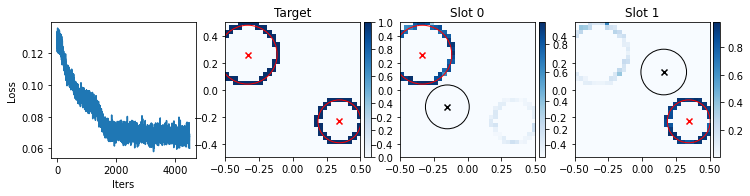

iter 4600 , loss 0.073613636 , lr 0.000155295986231874


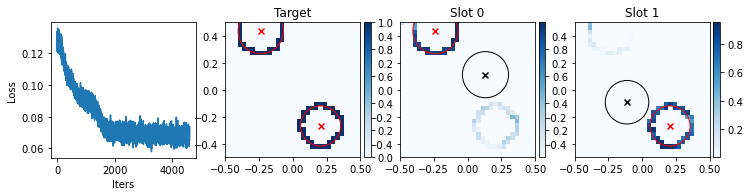

iter 4700 , loss 0.06733203 , lr 0.00015426927217791054


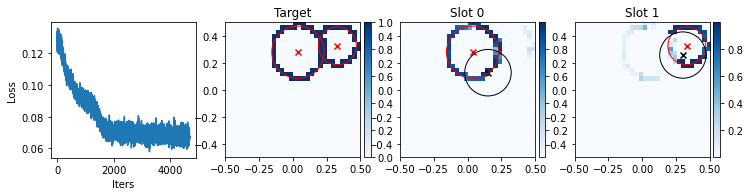

iter 4800 , loss 0.06618565 , lr 0.00015304183481222111


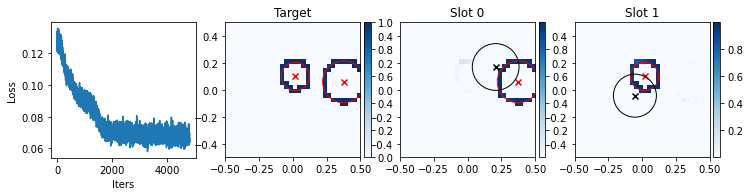

iter 4900 , loss 0.067041814 , lr 0.00015161738158448484


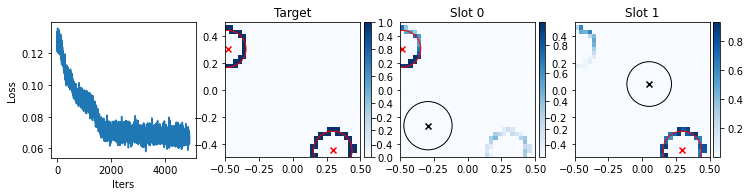

iter 5000 , loss 0.074607074 , lr 0.00015


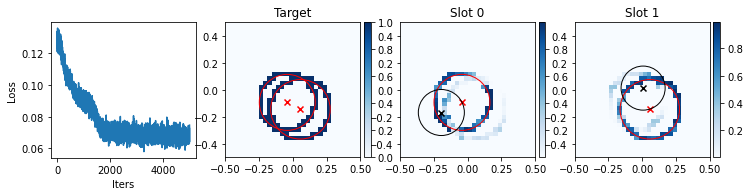

iter 5100 , loss 0.06626974 , lr 0.00014528838613828076


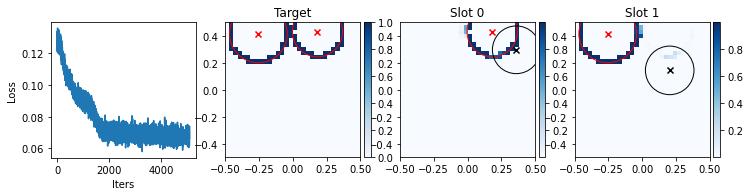

iter 5200 , loss 0.067619964 , lr 0.00014058142207060302


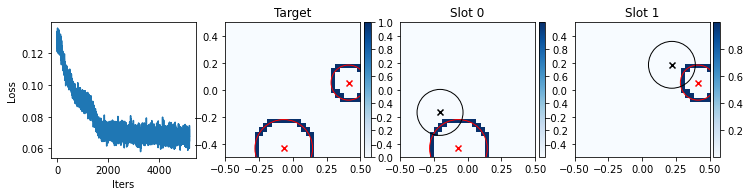

iter 5300 , loss 0.06881775 , lr 0.00013588375300222283


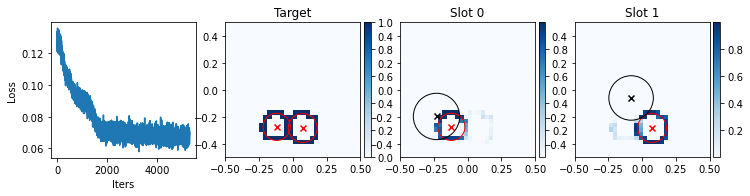

iter 5400 , loss 0.069457114 , lr 0.00013120001496535433


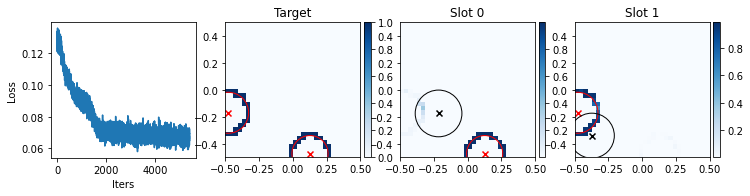

iter 5500 , loss 0.063230015 , lr 0.0001265348302439654


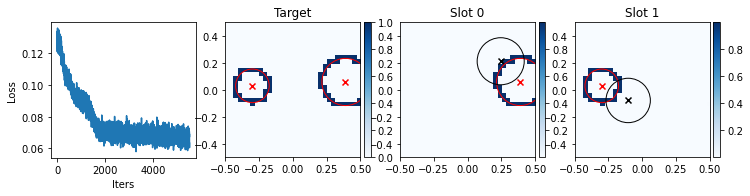

iter 5600 , loss 0.065438166 , lr 0.00012189280281214133


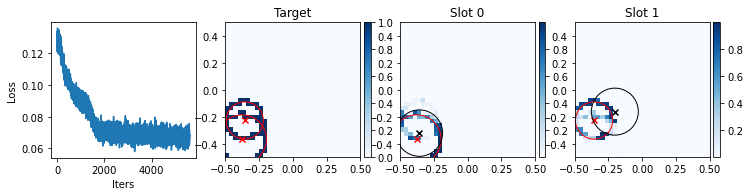

iter 5700 , loss 0.06869735 , lr 0.00011727851379051865


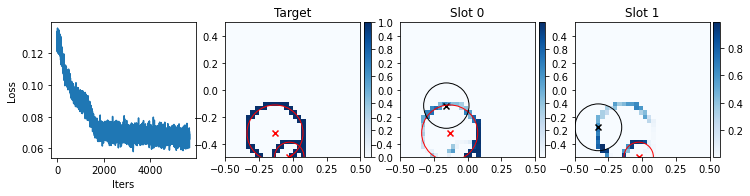

iter 5800 , loss 0.06446414 , lr 0.0001126965169252718


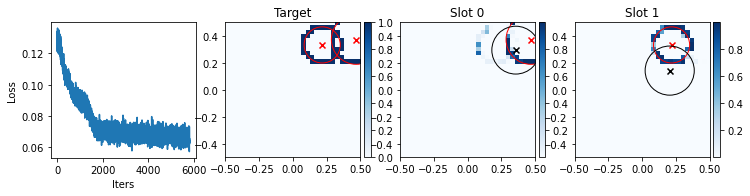

iter 5900 , loss 0.07432488 , lr 0.00010815133409411562


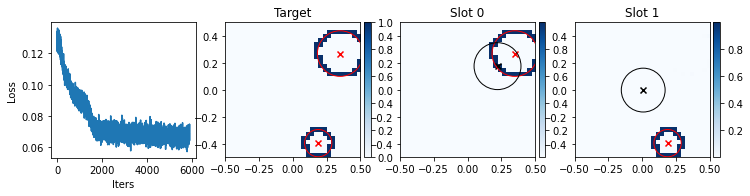

iter 6000 , loss 0.068707794 , lr 0.0001036474508437579


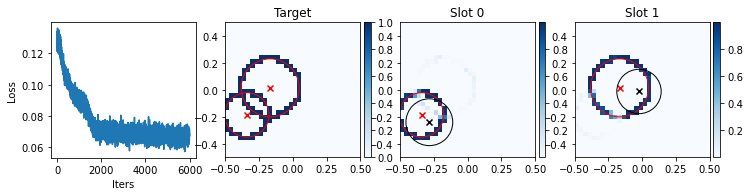

iter 6100 , loss 0.064046085 , lr 9.918931196320629e-05


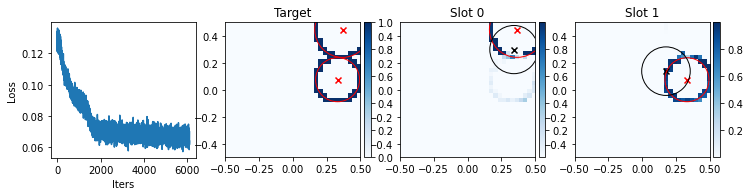

In [ ]:
m_reg,losses = train(m_base,m_reg, Ntrain = 10_000, bs=256,  lr=3e-4, warmup_steps=5_000,
                 device=device,plot_every=100)